# Comparing Ridge and Lasso Regression using Wine Dataset

## Overview:

In this project, I will fit a polynomial regression of wine quality on wine chemical data. And use ridge and lasso regularization to avoid overfitting. The two techniques will be compared, and cross validation is used to pick the optimal regularization strength.


In [31]:
import numpy as np
import pandas as pd
 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso, lars_path
from sklearn.preprocessing import PolynomialFeatures

import warnings; warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

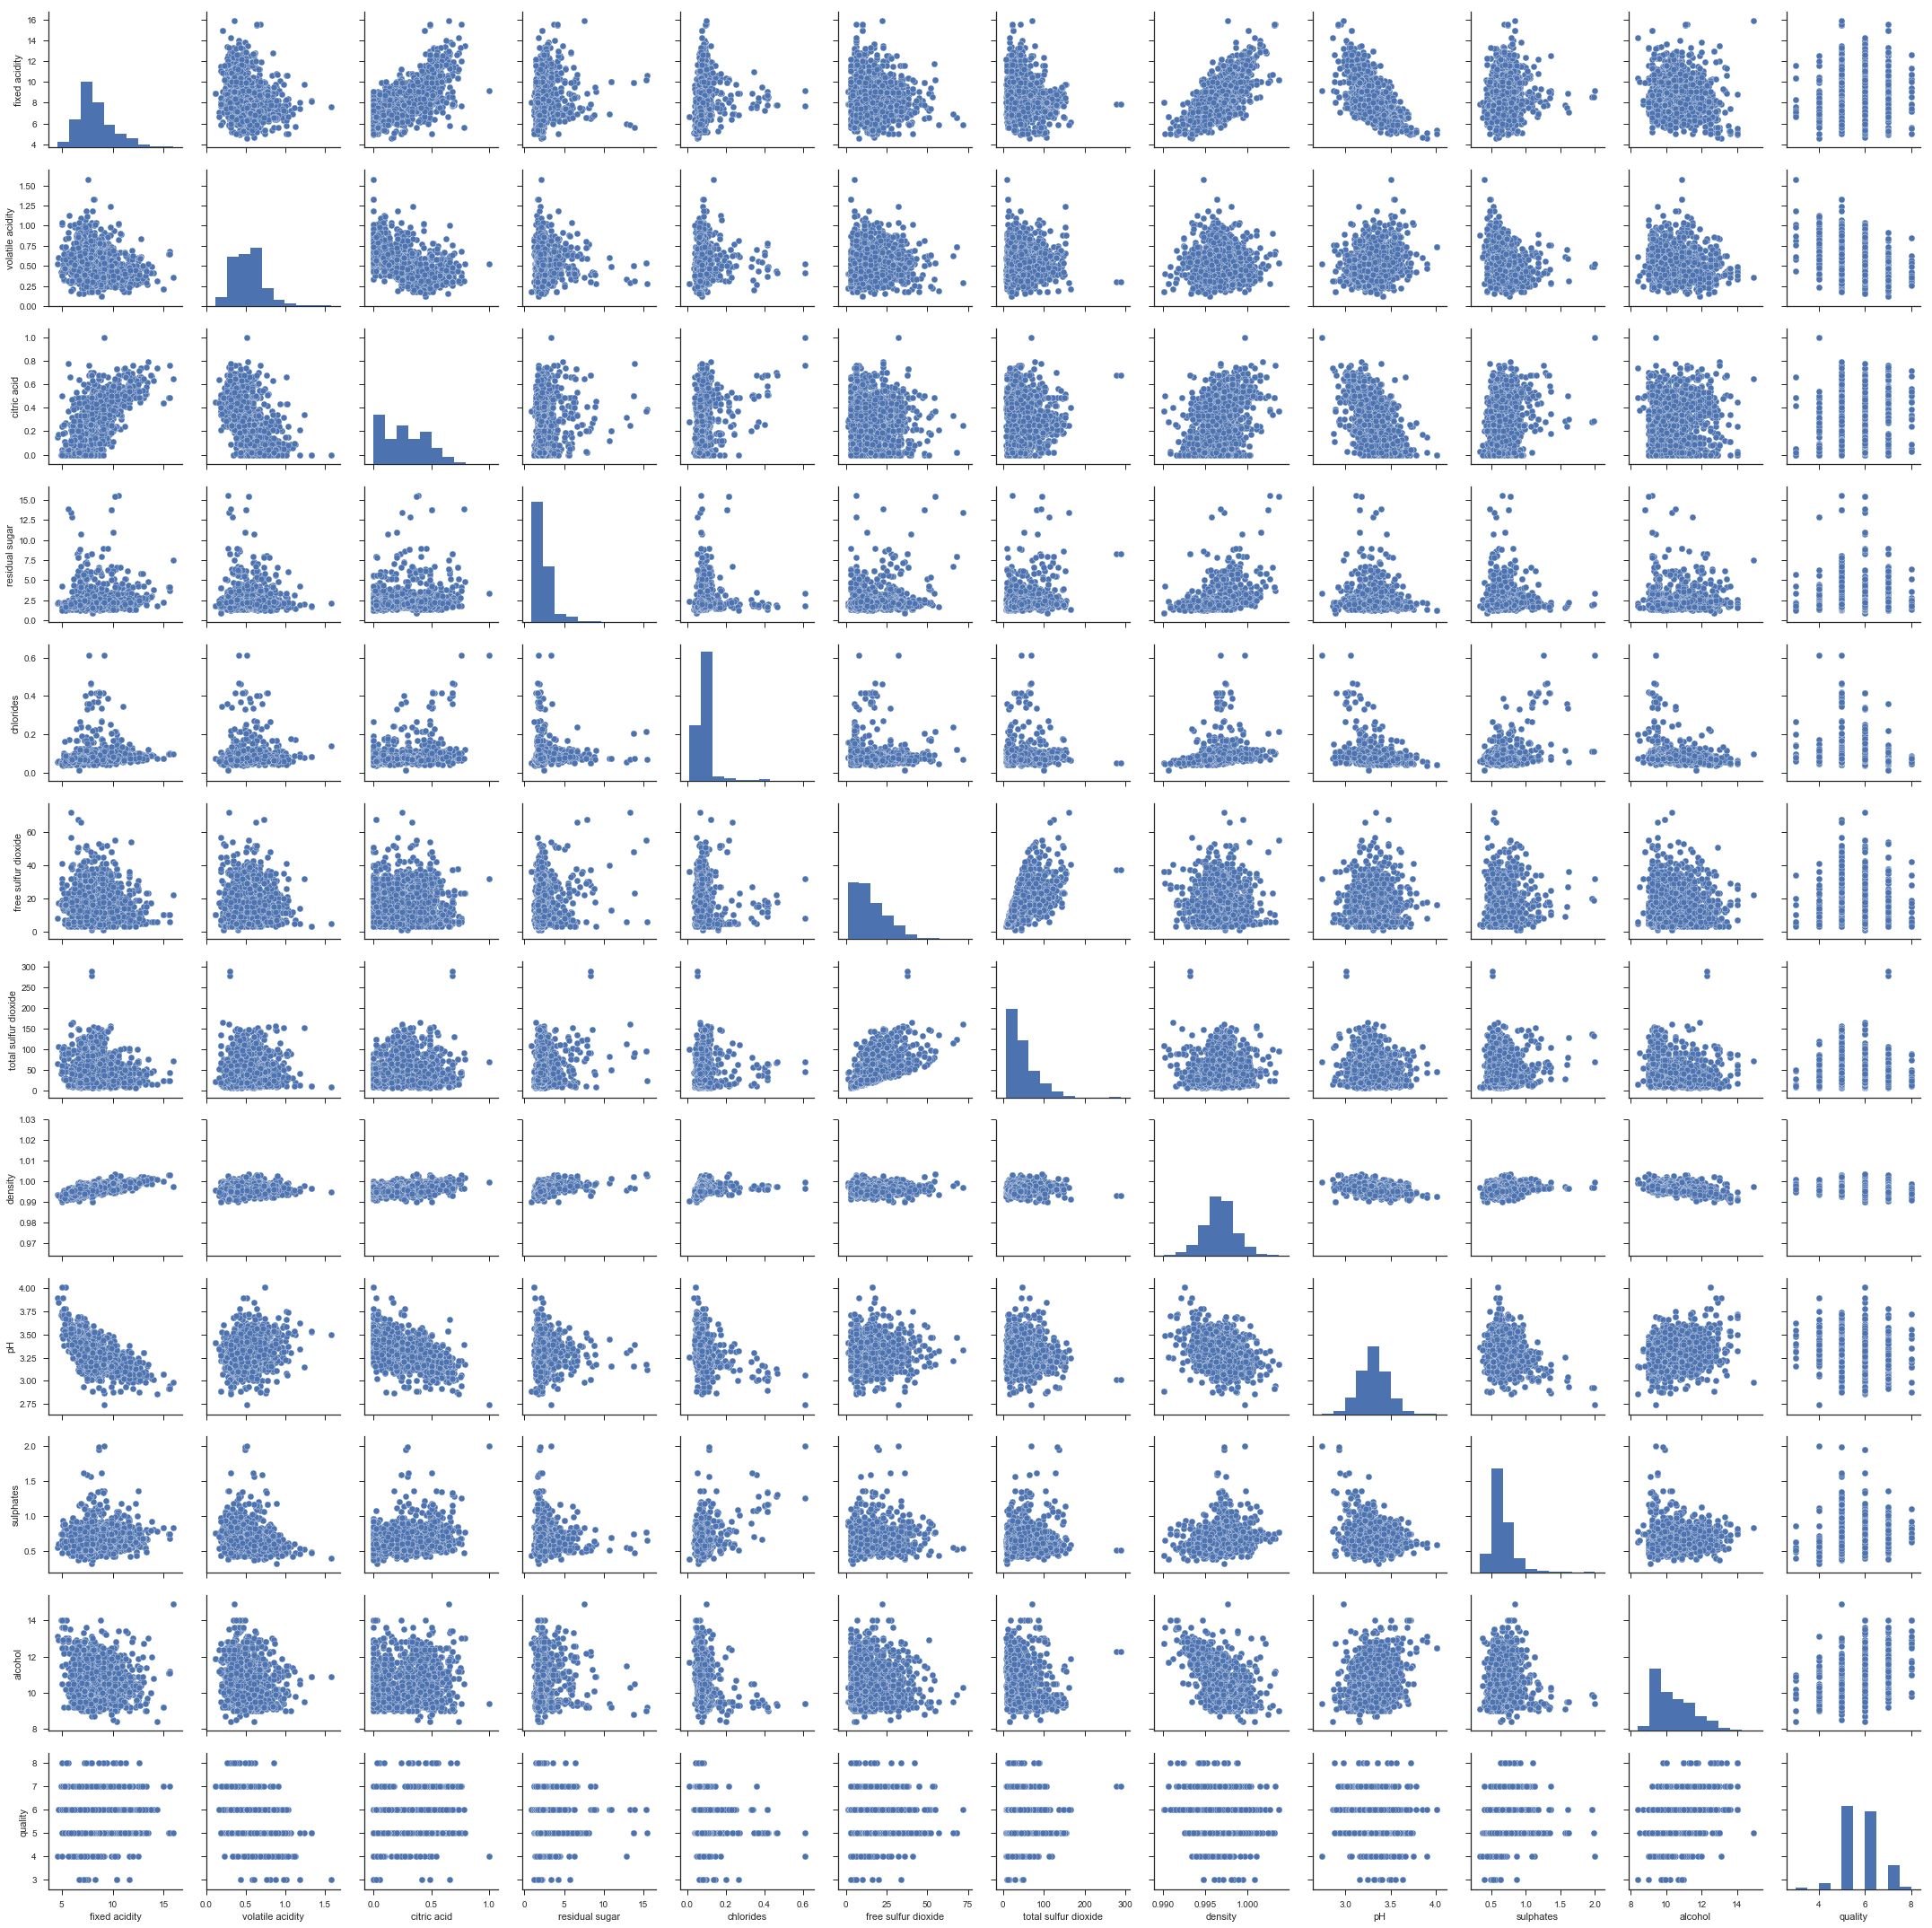

In [32]:
dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(dataset_url, sep=';')
data.head()

sns.set(style="ticks")
sns.pairplot(data)
plt.show()

Let's take a look at the data. From the data shown at the scatterplot matrix, the data seems highly non linear. Therefore to do a regression, we must introduce polynomial terms to model the non-linearity. In reality, a suport vector machine will probably do a better job for this prediction analysis. But since I want to work on ridge and lasso regularization, a polynomial of degree 3 will be used instead.

We will be predicting the quality of the wine using all the other variables as predictors. So we will first drop quality in the data set and assign it to y and split the dataset into 80% training set and 20% test set. It is important to split the training and test set at the beginning of the project to not 'leak' information to the test set and cause bias the result.


In [33]:


X = data.drop('quality', axis=1)
y = data.quality
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y)

 

## Polynomial Expansion of Independent Variables

If the underlying relation between the independent variables x and dependent variable y are not linear, a polynomial transform of the independent variables used as predictors will likely yield better result. This is due to a polynomial is more flexible and fit non linear relationships better. Theoretically, a polynomial with high enough order can approximate any function (Taylor's series expansion). However in practice, the number of predictor will explode in a multivariate regression with a high degree polynomial. In this case, I will use polynomial with degree 3.


In [34]:
poly = PolynomialFeatures(degree=3)
X_train_p = poly.fit_transform(X_train)


## Ridge Regularization

First, I will use the ridge function in sklearn with a range of alpha to see how the parameters shrink as alpha increases. Ridge regression used the L2 distance of the parameters as a cost to the regression.

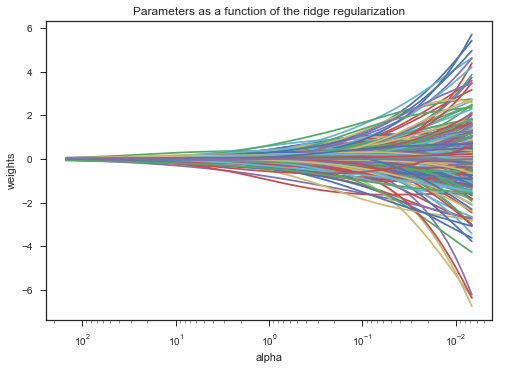

In [35]:
# ridge parameter shrinkage
l_alpha = np.linspace(-5,5)
params=[]
for i in l_alpha:
    ridge=Ridge(alpha=np.exp(i), fit_intercept=False)
    ridge.fit(X_train_p, y_train)
    params.append(ridge.coef_)

fig,ax = plt.subplots()


ax.plot(np.exp(l_alpha), params)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Parameters as a function of the ridge regularization')
plt.axis('tight')
plt.show()

fig.savefig('results.png')




## Lasso Regularization

Here we see that the coefficients slowly decrease as alpha increases. But the coefficients never reach 0. This is because the level sets of the ridge cost forms circles on a 2D space (hyperspheres in high dimensions). And the level sets of the residual sum of squares (RSS) forms an ellipse. The intersection of the ellipse and circle are likely to happen not on the axis.

Now let's use a Lasso regularisation to see how the parameters decrease.

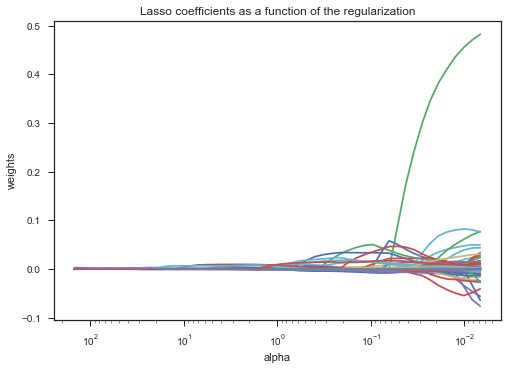

In [36]:
params=[]
for i in l_alpha:
    lasso=Lasso(alpha=np.exp(i), fit_intercept=False)
    lasso.fit(X_train_p, y_train)
    params.append(lasso.coef_)
    
ax = plt.gca()

ax.plot(np.exp(l_alpha), params)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

It seems that a lot of the parameters are reaching 0. Let's plot a line where a parameter reaches 0 to better visualize.

.

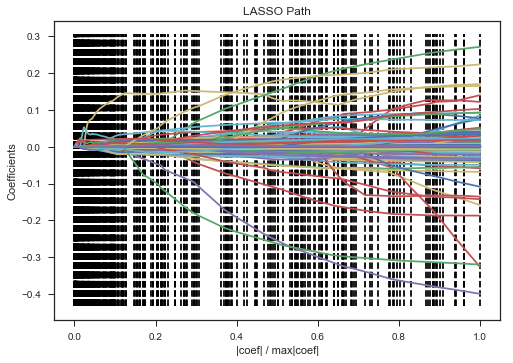

In [37]:
alphas, _, coefs = lars_path(X_train_p, y_train, method='lasso', verbose=True)
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.show()

## Comparison
The parameters are all reaching 0 as the regularization parameter alpha increases. The Lasso regularization uses L1 distance as a cost function which forms hypercubes in the solution space. The hypercube is much more likely to intercept the RSS ellipse at a corner where some of the parameters are 0.

Below is a graph I found that explain the difference between Ridge and Lasso regularization. Image from:
 [https://gerardnico.com/wiki/data_mining/lasso]


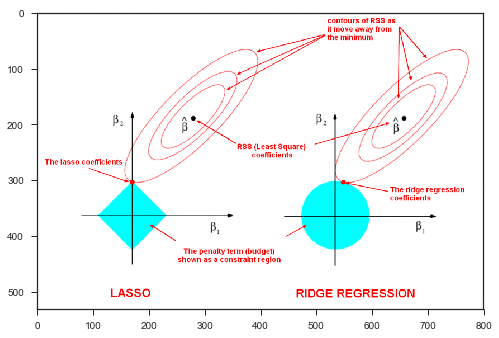

In [38]:
img=mpimg.imread('lasso_vs_ridge_regression.png')
imgplot = plt.imshow(img)
plt.show()

## Cross Validation and Results
One great way to choose alpha is to use the cross validation method. Cross validation withhold some training data before fitting the model parameters and use the withheld data to estimate the model error. This process is done many times by withholding different part of the model data (folds). The alpha with the lowest validation error is chosen. Note, the test set is not used as this stage, and can only be used at the end when the model fitting is completely finished to avoid leaking information.


In [39]:
ridgeCV=RidgeCV(alphas=np.exp(l_alpha), normalize=True,cv=10)
ridgeCV.fit(X_train_p, y_train)

X_test_p=poly.fit_transform(X_test)
ridgeCV.predict(X_test_p)
ridge_score=ridgeCV.score(X_test_p, y_test, sample_weight=None)

ridgeCV.coef_


array([  0.00000000e+00,   2.97085099e-03,  -1.08399467e-03,
        -8.33801389e-04,  -1.68276021e-03,   6.89789857e-04,
         1.84057785e-03,  -6.76208750e-03,  -6.33920517e-05,
        -1.71725382e-04,   1.27380453e-03,  -8.41695375e-04,
         5.96595486e-03,  -4.25682629e-04,  -7.81860852e-03,
        -6.05715355e-03,   3.00069002e-03,   2.92754238e-02,
        -1.07724271e-02,   2.41414979e-03,   6.68267006e-03,
         5.60564477e-03,   3.01001259e-02,  -7.65546828e-04,
         4.42917751e-05,  -2.00770379e-03,   7.72140005e-04,
        -7.95743854e-03,  -1.20247916e-02,  -1.10106197e-03,
        -1.37503021e-03,  -2.70034518e-04,  -9.34508370e-03,
         4.82729261e-05,  -3.10845227e-03,   3.42250666e-04,
         8.29809665e-03,   9.02957068e-03,  -8.66324153e-04,
        -5.24766239e-03,  -4.65359128e-04,  -1.69114074e-03,
        -1.80635170e-02,   2.82264657e-03,   5.96874067e-04,
         1.59906850e-02,  -1.92736709e-03,  -2.23343105e-03,
         2.56657165e-03,

In [40]:

lassoCV=LassoCV(alphas=np.exp(l_alpha), normalize=True,cv=10)
lassoCV.fit(X_train_p, y_train)

lassoCV.predict(X_test_p)
lasso_score=lassoCV.score(X_test_p, y_test, sample_weight=None)

lassoCV.coef_


array([ 0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.  

In [41]:
ridge_score


0.27102534333001516

In [42]:
lasso_score

0.13311702344887399

As we can see above, Ridge regularization shrank many coefficients to miniscule values and Lasso regularization drove most of the parameters to 0. In this case, ridge regularization produced a model with a better predictive power (measured by R^2), however the Lasso regularization is more interpretable. 

In addition to linear regression techniques, one might also use other techniques such as clustering, and tree based model, which might lead to a better result. This might be a potential expension of the project

